# Соберем сверточную нейронную сеть LiNet5

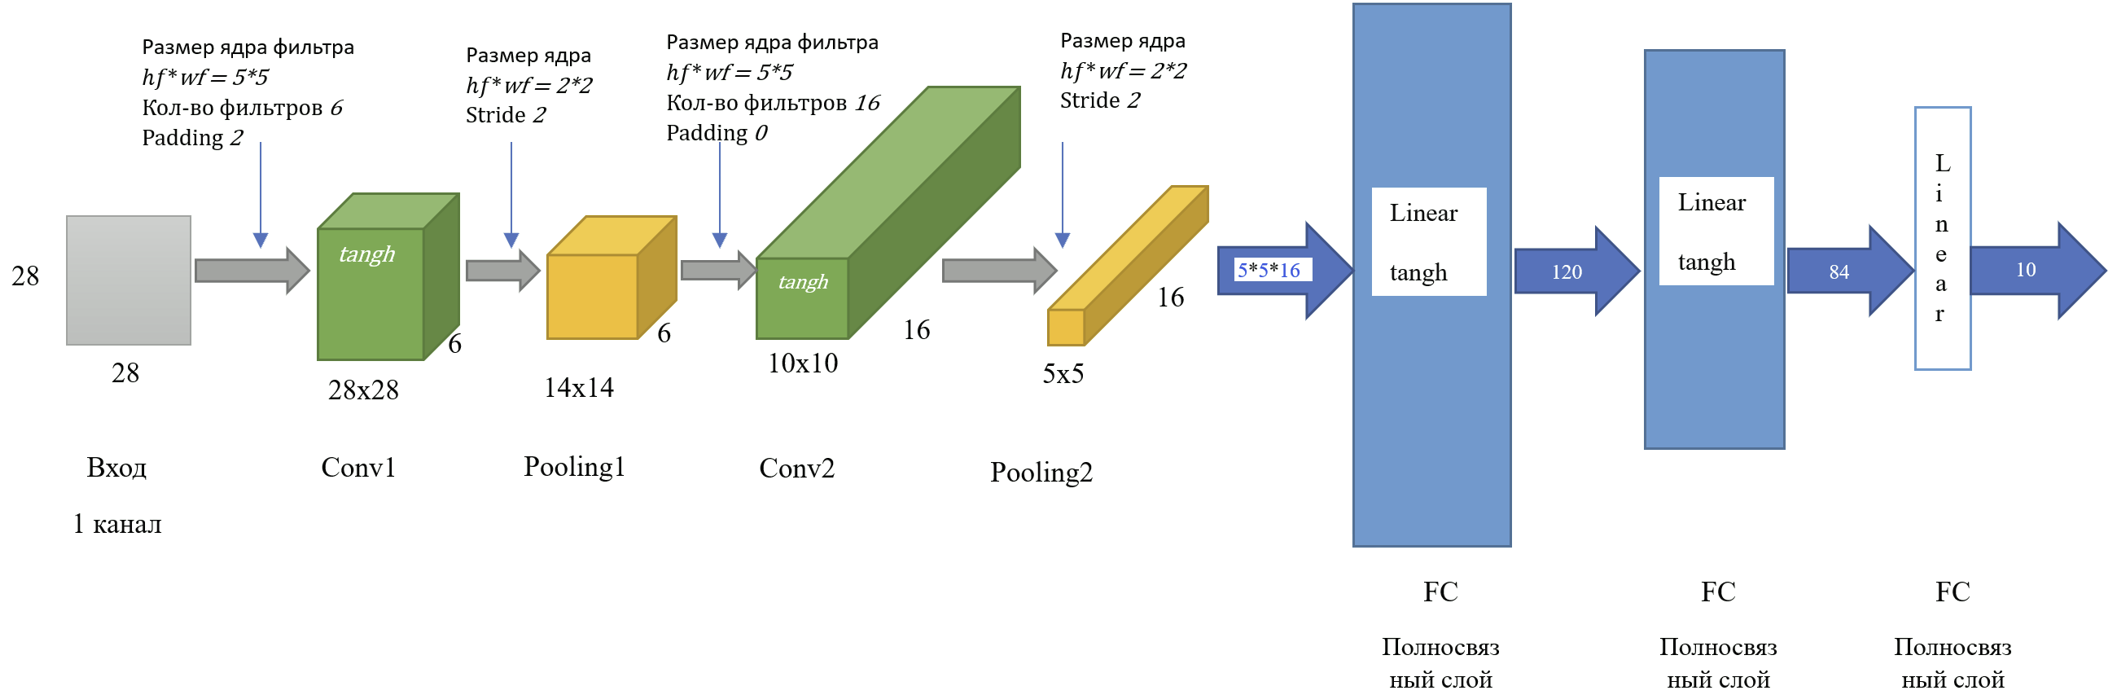


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет 28 × 28, функция активации tangh;
**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет 14 × 14, функция активации AvgPooling;
**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет 10 × 10, функция активации tangh;
**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет 5 × 5, функция активации AvgPooling;
**Слой FC** представляет собой полносвязанный слой, вход 5*5*16 нейронов (признаков), выход 120 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 120 нейронов (признаков), выход 84 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 84 нейронов (признаков), выход 10 нейронов;



In [111]:
# импортируем библиотеки

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [112]:
# это для cuda .
#torch.cuda.memory_summary(device=None, abbreviated=True)

In [113]:
# это для cuda. принудительно освобождение памяти, что иногда, но очень редко, помогает решить проблему с отказом
# cuda использовать память
#import gc
#gc.collect()

#torch.cuda.empty_cache()

In [114]:
# будем использовать встроенные датасеты торча.
# полный список - тут https://pytorch.org/vision/stable/datasets.html


import torchvision.datasets

In [115]:
# загружаем сразу в трайн и тест
cifar100_train = torchvision.datasets.CIFAR100('./', download=True, train=True)
cifar100_test = torchvision.datasets.CIFAR100('./', download=True, train=False)


Files already downloaded and verified
Files already downloaded and verified


In [116]:
# формируем датасеты для обучения, тестирования, целевые переменные

X_train = torch.tensor(cifar100_train.data).float()
y_train = torch.tensor(cifar100_train.targets)
X_test = torch.tensor(cifar100_test.data).float()
y_test = torch.tensor(cifar100_test.targets)


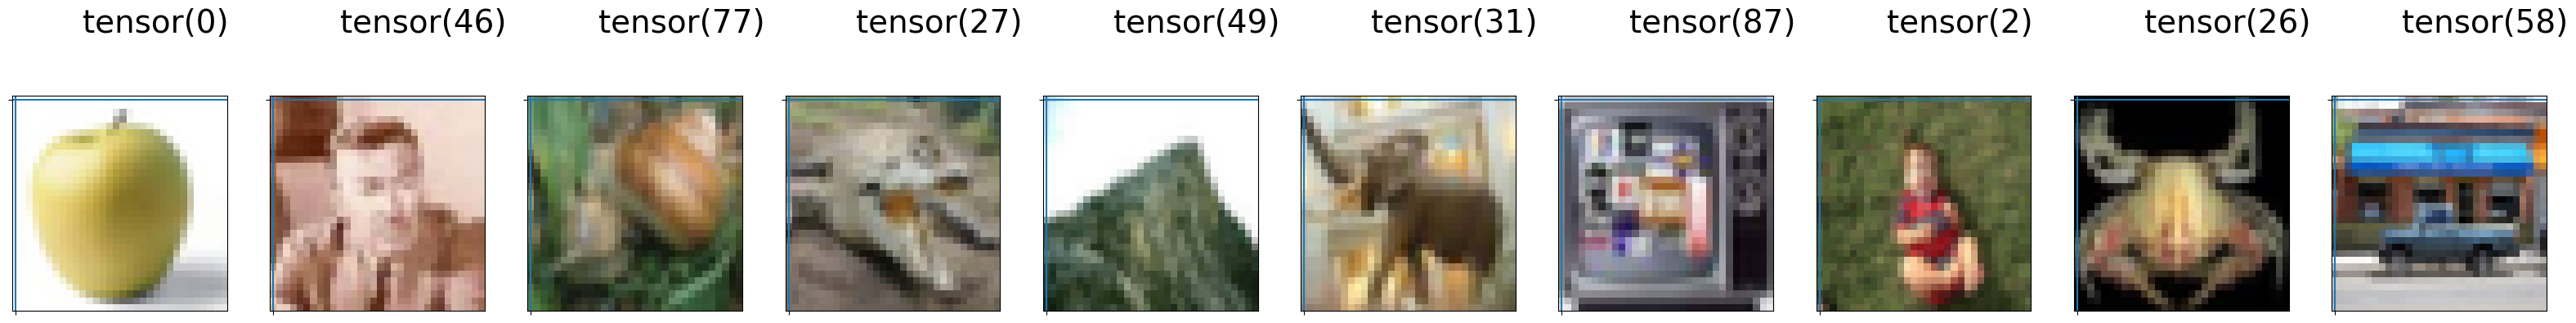

In [117]:
# посмотрим, что пришло
import numpy as np
import matplotlib.pyplot as plt
count = 0
sample_size = 10  # Сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
X_train = X_train / 255.0
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count += 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=str(y_train[i]), fontsize=28)
    plt.imshow(X_train[i])
plt.show()


In [118]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(50000, 10000)

image:
tensor([[[0.3255, 0.5176, 0.6980],
         [0.2627, 0.4471, 0.6275],
         [0.2392, 0.4235, 0.6039],
         ...,
         [0.0353, 0.1020, 0.2235],
         [0.0627, 0.1333, 0.2588],
         [0.1373, 0.2314, 0.3686]],

        [[0.2941, 0.4863, 0.6784],
         [0.2784, 0.4667, 0.6549],
         [0.2157, 0.4039, 0.5961],
         ...,
         [0.1529, 0.2627, 0.4196],
         [0.0353, 0.1098, 0.2549],
         [0.0471, 0.1216, 0.2588]],

        [[0.2863, 0.4745, 0.6784],
         [0.2667, 0.4510, 0.6510],
         [0.2902, 0.4784, 0.6745],
         ...,
         [0.3569, 0.5176, 0.6980],
         [0.2078, 0.3255, 0.4902],
         [0.0549, 0.1333, 0.2745]],

        ...,

        [[0.6235, 0.7333, 0.8745],
         [0.5882, 0.5725, 0.6235],
         [0.7490, 0.6039, 0.5608],
         ...,
         [0.5961, 0.5137, 0.5333],
         [0.6784, 0.5608, 0.6196],
         [0.4784, 0.4824, 0.5882]],

        [[0.6157, 0.6706, 0.7922],
         [0.6078, 0.5216, 0.5176],
     

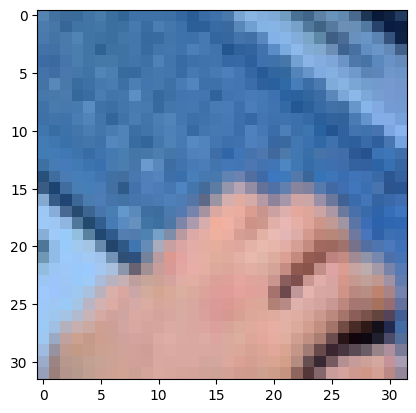

tensor(39)


In [119]:
# нарисуем, c чем мы имеем дело
import matplotlib.pyplot as plt

im_number = 10

# вот как хранятся изображения в компьютере
print(f"image:\n{X_train[im_number, :, :]}")

# а так их видим мы
plt.imshow(X_train[im_number, :, :])

plt.show()
print(y_train[im_number])

In [120]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [121]:
X_train.shape

torch.Size([50000, 32, 32, 3])

In [122]:
# Меняем оси на [N, C, H, W]
X_train = X_train.permute(0, 3, 1, 2)  # Теперь будет torch.Size([50000, 3, 32, 32])
X_test = X_test.permute(0, 3, 1, 2)    # Аналогично для тестового набора

In [123]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [124]:
X_test.shape

torch.Size([10000, 3, 32, 32])

In [125]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(64 * 6 * 6, 120)
        self.act3 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(84, 100)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# Создайте экземпляр нейронной сети
lenet5 = LeNet5()


In [126]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

# ЕСЛИ ВЫ ОБУЧИТЕ НЕЙРОНКУ НА GPU или CPU ОНА ДЛЯ СВОЕЙ РАБОТЫ БУДЕТ ТРЕБОВАТЬ ИЛИ GPU, ИЛИ CPU
Поэтому не всегда возможно использование обучения на GPU просто потому, что сервер или компьютер пользователя не будет поддерживать расчеты на GPU

In [127]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [128]:
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []


train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())


    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.08479999750852585 
epoch1 - accuracy test 0.10949999839067459 
epoch2 - accuracy test 0.14019998908042908 
epoch3 - accuracy test 0.14190000295639038 
epoch4 - accuracy test 0.15469999611377716 
epoch5 - accuracy test 0.12600000202655792 
epoch6 - accuracy test 0.12870000302791595 
epoch7 - accuracy test 0.14899998903274536 
epoch8 - accuracy test 0.13499999046325684 
epoch9 - accuracy test 0.13490000367164612 
epoch10 - accuracy test 0.12529999017715454 
epoch11 - accuracy test 0.14180000126361847 
epoch12 - accuracy test 0.12029999494552612 
epoch13 - accuracy test 0.12319999933242798 
epoch14 - accuracy test 0.11449999362230301 
epoch15 - accuracy test 0.13529999554157257 
epoch16 - accuracy test 0.13490000367164612 
epoch17 - accuracy test 0.11909999698400497 
epoch18 - accuracy test 0.1306999921798706 
epoch19 - accuracy test 0.11629999428987503 
epoch20 - accuracy test 0.10749999433755875 
epoch21 - accuracy test 0.10579999536275864 
epoch22 - accuracy te

<ipython-input-129-fd538a322c0e>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


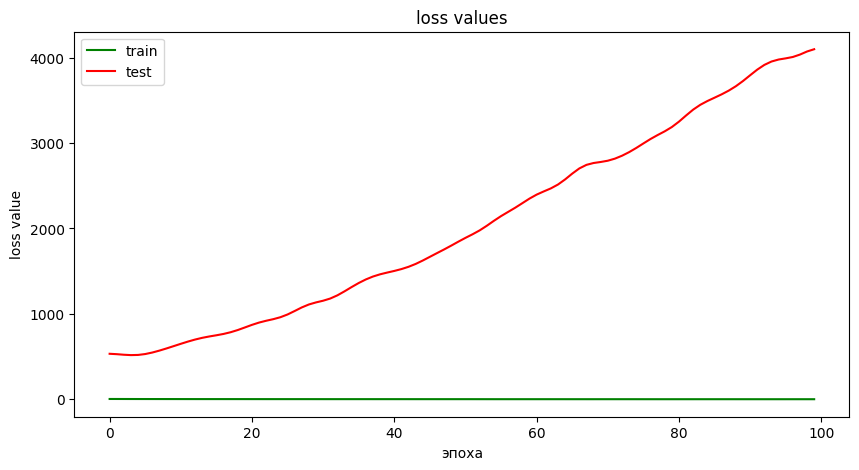

In [129]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



<ipython-input-130-7ea75e20b699>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


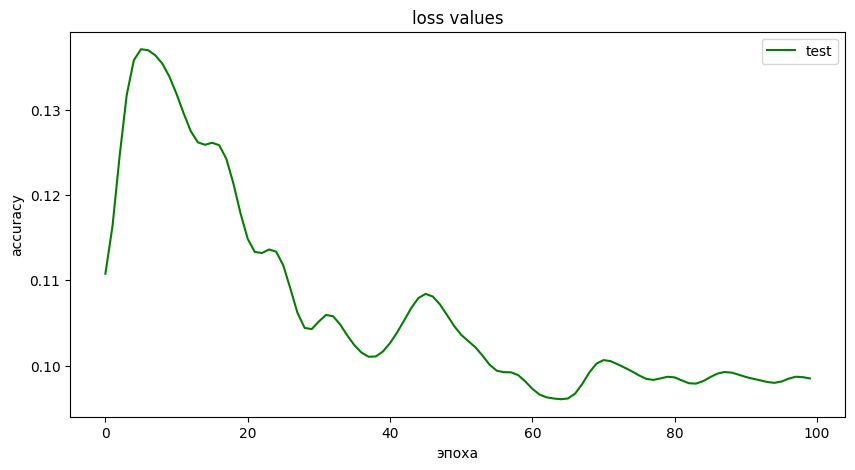

In [130]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

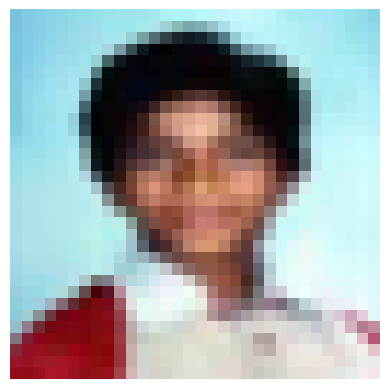

In [131]:
# Смотрим фотки, чтобы сохранить одну из них
timg = X_train[3]

# Изменяем порядок осей на [H, W, C] для отображения
timg_display = timg.permute(1, 2, 0)  # Переставляем оси

# Отображаем изображение
plt.imshow(timg_display.numpy())  # Преобразуем в numpy для отображения
plt.axis('off')  # Отключаем оси, если нужно
plt.show()


In [132]:
# сохраняем фото из датасета (тензор) в файл
timg = X_train[3]

torch.save(timg,'tensor.pt')

In [133]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([3, 32, 32])

In [134]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()

# то есть нам нужен тензор размера [1,1,28,28]

torch.Size([10000, 3, 32, 32])

In [135]:
pip install dill

In [136]:
# вот так сохраняют модель с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [137]:
# вот так сохраняют модель с помощью pickle
import pickle

with open("model.pickle", "wb") as pickle_file:
    pickle.dump(lenet5, pickle_file)



In [138]:
# считываем модель, сохраненную в dill
import torch
import torch.nn as nn
#from LeNET_5 import LeNet
import pandas as pd
import numpy as np



ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


<ipython-input-138-58d101a88a51>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


LeNet5(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)


In [139]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

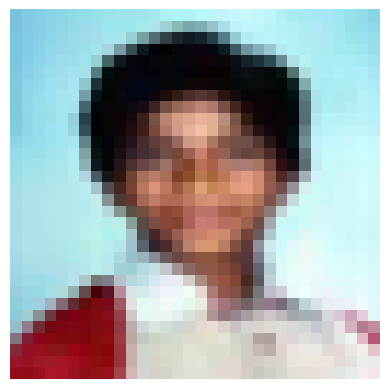

In [140]:
# Изменяем порядок осей на [32, 32, 3]
test_data = test_data.permute(1, 2, 0)  # Переставляем оси

# Теперь можно отображать изображение
plt.imshow(test_data.numpy())  # Преобразуем в numpy для отображения
plt.axis('off')  # Отключаем оси, если нужно
plt.show()

In [141]:
# переводим входной тензор-изображение в тензор нужного нам размера
# Преобразуем test_data в нужный формат
t_data = test_data.permute(2, 0, 1)  # Меняем порядок на [C, H, W]
t_data = t_data.unsqueeze(0)  # Добавляем размерность для батча, получаем [1, C, H, W

In [142]:
# проверяем
t_data.shape

torch.Size([1, 3, 32, 32])

In [143]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [144]:
# делаем предсказание
preds = modelp.forward(t_data)

In [145]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[ -9.1925, -48.1602,  15.8806, -28.1609, -26.8711, -86.2837, -30.6392,
         -19.2378, -15.1977, -15.5302,  -8.9459,  23.7616, -25.0475, -20.3911,
         -29.7987, -36.6677, -14.9719, -23.4169, -12.3806, -13.5027, -57.6123,
          -7.7475,  -2.9304, -30.5403, -14.3250, -29.2993,  -9.0654, -43.1206,
         -24.4474, -12.2838, -20.1828, -23.1980,  -2.2887, -35.2177, -42.3567,
          13.8704, -29.9690, -66.4590, -10.8017,  -2.3166, -13.3101, -22.8643,
         -31.8838, -54.3496, -15.6586,  -0.6568,  18.2223, -55.0297, -24.0621,
         -27.2105, -15.8891, -18.9514, -33.3044, -42.6371, -44.5361, -11.3309,
         -35.2643, -15.7449, -52.5756, -11.0550, -71.5560, -20.0713, -33.9482,
         -23.2481,  -0.9653, -11.4374,  19.3425, -11.8960, -57.7067, -41.2080,
         -32.8847, -98.9370,  -9.6699, -21.4687, -26.7593, -74.9528,  -6.1916,
         -41.7905, -22.7467, -26.4640, -21.6515, -55.6814, -36.1517, -24.4950,
         -47.7698, -35.0707,  -5.7014, -24.5001, -19

In [146]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [147]:
# смотрим, что предсказалось
print(prediction)

[11]


Судя по документации это мальчик, что правильно